Prepare the data.

In [1]:
import pandas as pd
import numpy as np
import csv

Transform raw data file into CSV file.

In [2]:
def parse_data(data_file, out_file):
    with open(data_file) as df:
        list=[]
        with open(out_file, mode='w') as training:
            data_writer = csv.writer(training, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            for x in range(0,37):
                if x==0:
                    feature="class"
                else:
                    feature ="feature"+str(x)
                list.append(feature)
            data_writer.writerow(list)
        line = df.readline()
        while line:
            data = line.split()
            parsedDataList=[]
            for x in range(0,37):
                parsedDataList.append("")

            for item in data:
                index=item.find(":")
                if index>0:
                    featureNumber=item[0:index]
                    featureData=item[index+1:]
                    parsedDataList[int(featureNumber)]=featureData
                else:
                    parsedDataList[0]=item
            with open(out_file, mode='a') as training:
                data_writer = csv.writer(training, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                data_writer.writerow(parsedDataList)
            line = df.readline()

In [3]:
parse_data("satimage.scale.training" , 'parsed_training.csv')
parse_data("satimage.scale.t" , 'parsed_testing.csv')

In [4]:
df_train = pd.read_csv('parsed_training.csv')
df_test  = pd.read_csv('parsed_testing.csv')

In [5]:
X = df_train.drop(['class'],axis=1)
y = df_train[['class']]

Normalize the data.

In [7]:
X =(X - X.mean())/ X.std()

In [8]:
X=X.fillna(0)

In [9]:
class_dict = {1:0, 2:0, 3:0, 4:0, 5:0, 6:1}
y=y['class'].map(class_dict)

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Imputer


def cross_validate_single_kernel(X, y, kernel, n_folds, args):
    
    #auc = []
    error = []
    nsv = 0
    nsvm = 0 
    skf=StratifiedKFold(n_splits=n_folds, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

        ##train/test
        svm = SVC(C=args["c_val"], kernel=kernel, tol=1e-7, shrinking=False, degree = args["d_val"], gamma = 'auto')
        svm.fit(X_train, y_train)

        error.append(len(y_test)-((svm.score(X_test, y_test))*len(y_test)))
        sv_list   =  svm.support_
        svx       =  svm.support_vectors_
        beta_list = abs(np.float16((svm.decision_function(svx))))
        index = [i for i, j in enumerate(beta_list) if j == 1]

        #pred   =   svm.predict(X_test)
        #auc.append(roc_auc_score(y_test, pred))
        nsv   +=   np.mean(svm.n_support_)/n_folds
        nsvm  +=   len(index)/n_folds
    
    return error, nsv, nsvm

In [22]:
c_vals     = 5
d_vals     = 3
cross_validate_single_kernel(X, y, "poly", 10, {"c_val":c_vals, "d_val":d_vals})

([33.0, 40.0, 33.0, 37.0, 27.0, 38.0, 36.0, 30.0, 39.0, 40.0],
 433.6,
 120.89999999999999)

Make it Parallel

In [12]:
from joblib import Parallel, delayed
import multiprocessing 
from itertools import product

num_processes = 8

def cross_validate_kernels(X, y, kernel, n_folds, args):
    
    for key in args.keys():
        if len(args[key])==0:
            args[key]=[1]

    results = Parallel(n_jobs=num_processes)(delayed(cross_validate_single_kernel)\
              (X, y, kernel, n_folds,{"c_val":c_val, "d_val":d_val})\
              for (c_val, d_val) in product(args["c_vals"], args["d_vals"]))
    
    names   = ["kernel:%s__log10_C:%s__degree:%s"%(kernel, str(np.log10(c_val)), str(d_val))\
              for (c_val, d_val) in product(args["c_vals"], args["d_vals"])]
    
    result_dict = dict(zip(names, results))
        
    return result_dict

In [30]:
import os

rslt_addr = "./results"
if not os.path.exists(rslt_addr):
    os.makedirs(rslt_addr)

In [31]:
def name_creator(kernel, n_folds, args):

    name = "kernel%s__n_folds%d"%(kernel, n_folds)
    
    def describe_in_string(vec, is_degree=False):
        
        if len(vec)==0:
            return "NA"
        
        if not is_degree:
            vec = np.log10(vec)
            
        if len(vec)==1:
            return "%d"%vec[0]
    
        return "%d~%d"%(np.min(vec), np.max(vec))
    
    for arg in sorted(args.keys()):
        if arg!="d_vals":
            name += "__log10_%s%s"%(arg, describe_in_string(args[arg]))
        else:
            name += "__%s%s"%(arg, describe_in_string(args[arg], True))
    
    return name

In [32]:
import pickle
import os
import numpy as np

def load_it_or_compute_it (X, y, kernel, n_folds, args):
    
    rslt_dict_name = name_creator(kernel, n_folds, args)
    rslt_dict_addr = os.path.join(rslt_addr, rslt_dict_name)
    
    print (rslt_dict_name)
    
    if os.path.isfile(rslt_dict_addr):
        print ("FOUND!")
        with open(rslt_dict_addr,"rb") as rslt_dict_handle:
            rslt_dict = pickle.load(rslt_dict_handle)
    else:
        rslt_dict = cross_validate_kernels(X, y, kernel, n_folds, args)
        with open(rslt_dict_addr,"wb") as rslt_dict_handle:
            pickle.dump(rslt_dict, rslt_dict_handle)

    return rslt_dict

In [3]:
c_vals     = np.power(float(5), range(-5, 5 + 1))
d_vals     = range( 1, 4 + 1)
rslt_dict = load_it_or_compute_it (X, y, "poly", 10, {"c_vals":c_vals, "d_vals":d_vals})
value_list = list(rslt_dict.items())

NameError: name 'load_it_or_compute_it' is not defined

In [4]:
test_list = np.reshape(value_list,(11, 8))
test_list = np.delete(test_list, [0 ,2, 4, 6], axis = 1)
#test_list = np.asfarray(test_list,float)
print(test_list)

NameError: name 'value_list' is not defined

Q1b

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})
import numpy as np

y_label = np.linspace(0,1.0,num=11)

def plot_errorC(c_vals, list):
    plt.figure(figsize = (16,10))
    plt.plot(range(len(c_vals)), [(np.mean(i[0][0])-np.std(i[0][0])) for i in list], color = 'b', label='d = 1')
    plt.plot(range(len(c_vals)), [(np.mean(i[1][0])-np.std(i[1][0])) for i in list], color = 'r', label='d = 2')
    plt.plot(range(len(c_vals)), [(np.mean(i[2][0])-np.std(i[2][0])) for i in list], color = 'c', label='d = 3')
    plt.plot(range(len(c_vals)), [(np.mean(i[3][0])-np.std(i[3][0])) for i in list], color = 'y', label='d = 4')
    
    plt.title('SVM Cross-Validation Error for Penalty Parameter C')
    plt.xlabel('C')
    ##plt.yticks(range(len(y_label)), y_label)
    plt.ylabel('Error')
    plt.xticks(range(len(c_vals)), c_vals, rotation='vertical')
    plt.legend(loc = 'best')
    plt.show()

In [2]:
plot_errorC(c_vals, test_list)

NameError: name 'c_vals' is not defined

Q1c

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})
import numpy as np

oc_index = 6
error_d=[]
for i in range(4):   
    error_d.append(np.mean(test_list[oc_index][i][0]))
y_label = np.linspace(0,1.0,num=11)

##print_list = float(float(list[10][1::2]))
def plot_errord(d_vals, list):
    plt.figure(figsize = (16,10))
    plt.plot(range(len(d_vals)), (error_d), color = 'black')
    
    plt.title('SVM Error vs Degree d')
    plt.xlabel('d')
    ##plt.yticks(range(len(y_label)), y_label)
    plt.ylabel('Error')
    plt.xticks(range(len(d_vals)), d_vals)
    plt.show()

NameError: name 'test_list' is not defined

In [6]:
plot_errord(d_vals, test_list)

NameError: name 'plot_errord' is not defined

Q1d

In [96]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})
import numpy as np

#svn_d=[]
#for j in range(4):   
#    svn_d.append([(np.mean(i[j][1]) for i in test_list)])
svn_d = [np.mean([(i[0][1]) for i in test_list]),np.mean([(i[1][1]) for i in test_list]), np.mean([(i[2][1]) for i in test_list]), np.mean([(i[3][1]) for i in test_list])]

y_label = np.linspace(0,1.0,num=11)

##print_list = float(float(list[10][1::2]))
def plot_svnd(d_vals, list):
    plt.figure(figsize = (16,10))
    plt.plot(range(len(d_vals)), (svn_d), color = 'black')
    
    plt.title('Average number of support vectors for Polynomial Degree d')
    plt.xlabel('d')
    ##plt.yticks(range(len(y_label)), y_label)
    plt.ylabel('number of support vectors')
    plt.xticks(range(len(d_vals)), d_vals)
    plt.show()

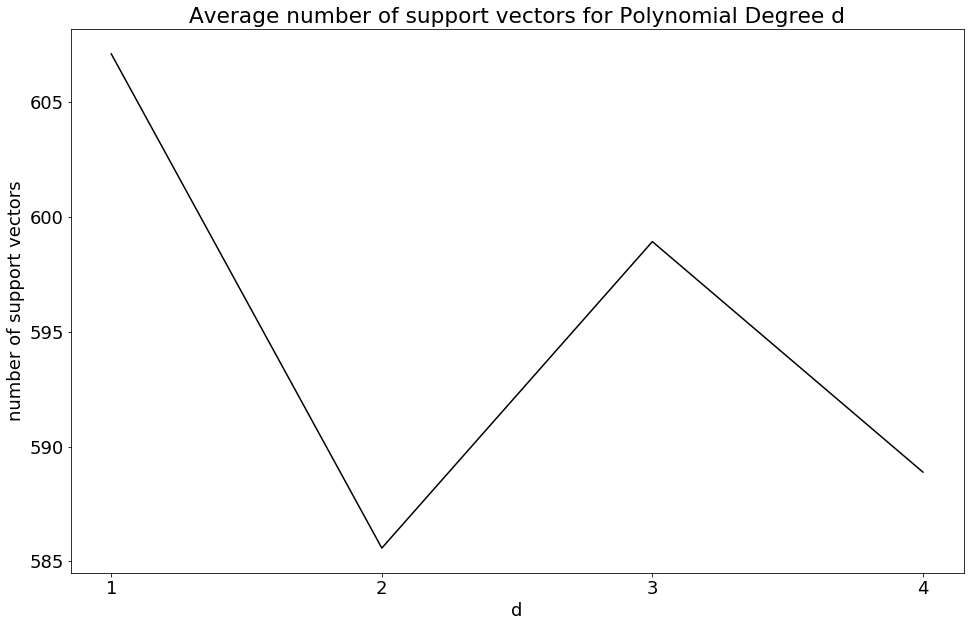

In [98]:
plot_svnd(d_vals, test_list)

Q1e

In [100]:
oc_index = 6
od_index = 1
print('Number of support vectors lie on the margin hyperplanes: %f'%test_list[oc_index][od_index][2])

Number of support vectors lie on the margin hyperplanes: 69.600000
